#PROBLEM 1: Recommender System using Collaborative Filtering
Implement a Movie Recommendation System and run it on the Movie Lens Dataset (Train vs Test). Mesure performance on test set using RMSE
1. First you are required to compute first a user-user similarity based on ratings and movies in common
2. Second, make rating predictions on the test set followoing the KNN idea: a prediction (user, movie) is the weighted average of other users' rating for the movie, weighted by user-similarity to the given user.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train_path = '/content/drive/MyDrive/Movie Lens Dataset/ml-100k/u1.base'
test_path = '/content/drive/MyDrive/Movie Lens Dataset/ml-100k/u1.test'

In [ ]:
train_df = pd.read_csv(train_path, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
test_df = pd.read_csv(test_path, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

In [ ]:
train_df.head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [ ]:
test_df.head()

,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [ ]:
print(train_df.shape,test_df.shape)

(80000, 4) (20000, 4)


In [ ]:
train_df.nunique()

,0
user_id,943
item_id,1650
rating,5
timestamp,43177


##Creating r_um (normalized rating of user u for movie m)

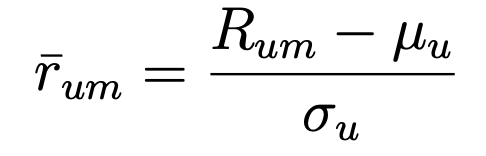

In [ ]:
r_um = [[0] * 1682 for i in range(943)]
r_um = np.array(r_um, dtype=float)

for i in range(len(train_df)):
  r_um[train_df.loc[i,'user_id']-1][train_df.loc[i,'item_id']-1] = train_df.loc[i,'rating']

In [ ]:
r_um

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [ ]:
means = []
stds = []
for i in range(r_um.shape[0]):
  mean = np.mean(r_um[i][r_um[i]!=0])
  std = np.std(r_um[i][r_um[i]!=0])

  means.append(mean)
  stds.append(std)

  r_um[i][r_um[i]!=0] = (r_um[i][r_um[i]!=0] - mean) / std

In [ ]:
means[0],stds[0]

(3.6814814814814816, 1.274547715578626)

In [ ]:
r_um[0][0] == (5-means[0])/stds[0]

True

##Computing user-user similarity

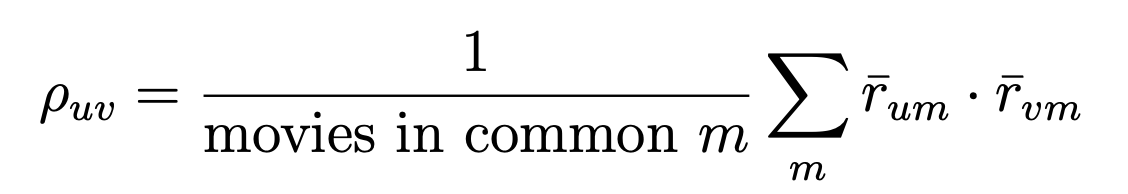

In [ ]:
user_sim = np.matmul(r_um, r_um.T)

In [ ]:
for i in range(user_sim.shape[0]):
  for j in range(user_sim.shape[1]):
    movies_in_common = np.count_nonzero(r_um[i] * r_um[j])
    if movies_in_common == 0:
      user_sim[i][j] = 0
    else:
      user_sim[i][j] = user_sim[i][j] / movies_in_common

In [ ]:
user_sim.shape

(943, 943)

##Predicting Rating

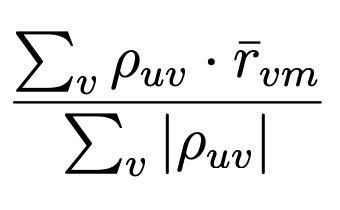

a prediction (user, movie) is the weighted average of other users' rating for the movie, weighted by user-similarity to the given user.

###For understanding

In [ ]:
test_df.head(200)

,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
195,5,1,4,875635748
196,5,2,3,875636053
197,5,17,4,875636198
198,5,24,4,879198229


In [ ]:
print(r_um[0][5],r_um[0][16],r_um[4][0],r_um[4][39])

0.0 0.0 0.0 0.0


In [ ]:
user = 0
movie = 16

weighted_average_rating_normalized = np.dot(r_um[:,movie],user_sim[user,:]) / (np.count_nonzero(user_sim[user,:]) - 1)

In [ ]:
(weighted_average_rating_normalized * stds[0])+means[0]

3.674676228775207

In [ ]:
print(test_df.loc[20000-1,'user_id'],test_df.loc[1,'item_id'],test_df.loc[1,'rating'])

462 10 3


###Prediction

In [ ]:
for i in range(test_df.shape[0]):
  user = test_df.loc[i,'user_id'] - 1
  movie = test_df.loc[i,'item_id'] - 1
  actual_rating = test_df.loc[i,'rating']

  weighted_average_rating_normalized = np.dot(r_um[:,movie],user_sim[user,:]) / (np.count_nonzero(user_sim[user,:]) - 1) # array sizes: 943
  predicted_rating = (weighted_average_rating_normalized * stds[user])+means[user]

  test_df.loc[i,'predicted_rating'] = predicted_rating

In [ ]:
test_df.head()

,user_id,item_id,rating,timestamp,predicted_rating
0,1,6,5,887431973,3.680169
1,1,10,3,875693118,3.683009
2,1,12,5,878542960,3.737261
3,1,14,5,874965706,3.699621
4,1,17,3,875073198,3.674676


In [ ]:
rmse = np.sqrt(np.mean((test_df['rating'] - test_df['predicted_rating'])**2))

In [ ]:
rmse

1.0572407911406585